done


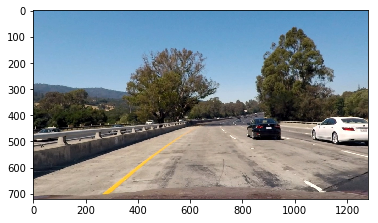

In [1]:
#Camera Calibration

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

#numbers of blocks in chessboard
nx = 9
ny = 6
shape = []
objPoints = [] #3D points in real world space
imgPoints = [] #2D points in image plane
images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    #plt.imshow(img)

    #Populate the object points for the chessboard
    objp = np.zeros((nx * ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    #convert image from RGB to Grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    shape = gray.shape[::-1]
    #Find the chessboard corners in the image
    ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    #If corners are found, add object points and image points 
    if ret == True:
        imgPoints.append(corners)
        objPoints.append(objp)
    
        img = cv2.drawChessboardCorners(img,(nx,ny),corners, ret)
  

if(len(objPoints) > 0):
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objPoints, imgPoints,shape,None,None)
    img = mpimg.imread('test_images/test1.jpg')
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    #cv2.imwrite('output_images/test1.jpg', cv2.cvtColor(dst,cv2.COLOR_RGB2BGR))
    plt.imshow(dst)
print('done')



In [2]:
class LaneDetection():
    def __init__(self):
        self.firstRun = True
        self.laneWindowDetected  = False
        self.recent_xfitted = []
        self.bestx = None
        self.mean_left_fit = []
        self.mean_right_fit = []
        self.current_fit = [np.array([False])]
        self.radius_of_curvature = None
        self.line_base_ps = None
        self.diffs = np.array([0,0,0],dtype='float')
        self.allx = None
        self.ally = None
        self.left_fit = []
        self.right_fit = []
            
    def region_of_interest(self,img, vertices):
        """
        Applies an image mask.
        
        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   
        
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image
    
    def canny(self,img, low_threshold, high_threshold):
        """Applies the Canny transform"""
        return cv2.Canny(img, low_threshold, high_threshold)
            

    def draw_lines(self,image, lines, color=[255, 0, 0], thickness=2):
        """
        NOTE: this is the function you might want to use as a starting point once you want to 
        average/extrapolate the line segments you detect to map out the full
        extent of the lane (going from the result shown in raw-lines-example.mp4
        to that shown in P1_example.mp4).  
        
        Think about things like separating line segments by their 
        slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
        line vs. the right line.  Then, you can average the position of each of 
        the lines and extrapolate to the top and bottom of the lane.
        
        This function draws `lines` with `color` and `thickness`.    
        Lines are drawn on the image inplace (mutates the image).
        If you want to make the lines semi-transparent, think about combining
        this function with the weighted_img() function below
        """
        
        imshape = image.shape
        leftMinY = 0
        leftMaxY = imshape[0]
        leftMinX = 0
        leftMaxX = 0
        
        rightMinY = 0
        rightMaxY = imshape[0]
        rightMinX = 0
        rightMaxX = 0
    
        m1 = 1
        m2 = 1
          
            
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2 - y1)/(x2- x1)
                if slope < 0:
                    m1 = slope
                    if(leftMinY < y1):
                        leftMinY = y1
                        leftMinX = x1
                    if(leftMaxY > y2):
                        leftMaxY = y2
                        leftMaxX = x2
                elif slope > 0:
                    m2 = slope
                    if(rightMinY < y2):
                        rightMinY = y2
                        rightMinX = x2
                    if(rightMaxY > y1):
                        rightMaxY = y1
                        rightMaxX = x1
                        
      
        
        leftMinX = np.uint16(leftMinX - ((leftMinY - imshape[0])/m1)) #x2 - (y2 - y1) / m1
        rightMinX = np.uint16(rightMinX - ((rightMinY - imshape[0] )/m2))
        
        alpha = 1
        
        #sanity check to prevent cross over of lane lines
        if rightMaxX - leftMaxX < 250 :
            alpha = .9
            leftMaxX = np.uint16(leftMinX + (alpha * (leftMaxX - leftMinX)))
            leftMaxY = np.uint16(leftMinY + (alpha * (leftMaxY - leftMinY)))
        
        
            rightMaxX = np.uint16(rightMinX + (alpha * (rightMaxX - rightMinX)))
            rightMaxY = np.uint16(rightMinY + (alpha * (rightMaxY - rightMinY)))
    
        rmy = rightMaxY
        rmx = rightMaxX
       
        #sanity check to bring lane lines to same length    
        if (leftMaxY < rightMaxY ):
            m2 =  (   imshape[0] - rightMaxY    ) /(   rightMinX  -rightMaxX   )
            rightMaxY = leftMaxY
            rightMaxX =  np.uint16( rightMinX - ((  imshape[0] - rightMaxY    ) / m2)  )
          
        if(rightMaxX > imshape[1] | rightMaxY > imshape[0]):
            #rightMaxY = rmy 
            #rightMaxX = rmx
            mid = np.uint16(imshape[1] / 2) 
            rightMinX = (mid - leftMinX ) + mid
            rightMaxX = (mid - leftMaxX ) + mid
            rightMaxY = leftMaxY
            rightMaxX = 704
            rightMinX = 1109
            
            self.laneDetected = False
        else:
            self.laneDetected = True
              
        
        #for debuging
        if 0 == 1:
            plt.figure()
            cv2.line(image, (leftMinX, imshape[0]), (leftMaxX, leftMaxY), color, thickness)
            cv2.line(image, (rightMinX, imshape[0]), (rightMaxX, rightMaxY), color, thickness)
            cv2.line(image, (leftMinX, imshape[0]), (leftMinX, 0), color, thickness)
            cv2.line(image, (rightMinX, imshape[0]), (rightMinX, 0), color, thickness)
    
            plt.figure()
            plt.subplot(2,1,1)
            plt.imshow(image)
        
        leftCorners = np.float32([[leftMinX, imshape[0]],[leftMaxX, leftMaxY],[rightMinX, imshape[0]],[rightMaxX, rightMaxY]])
        rightCorners = np.float32([[leftMinX, imshape[0]],[leftMinX, 0],[rightMinX, imshape[0]],[rightMinX, 0]])

        return leftCorners, rightCorners
       
    
    def hough_lines(self,img, rho, theta, threshold, min_line_len, max_line_gap):
        """
        `img` should be the output of a Canny transform.
            
        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        corners1, corners2 = self.draw_lines(self.img, lines,thickness=6)
        return line_img, corners1, corners2
    
    # Python 3 has support for cool math symbols.
    
    def weighted_img(self,img, initial_img, a=0.8, b=1., c=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.
        
        `initial_img` should be the image before any processing.
        
        The result image is computed as follows:
        
        initial_img * a + img * b + c
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, a, img, b, c)
    
    def abs_sobel_tresh(self,img,orient = 'x',sobel_kernal=3,mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on sobel operation
        '''
        
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        if orient =='x':
            abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernal))
        else:
            abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernal))
      
        scaled_sobel = np.uint(255*abs_sobel/np.max(abs_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= mag_tresh[0]) & (scaled_sobel <= mag_tresh[1])] = 1
        return binary_output


    def mag_tresh(self,img,sobel_kernal=3,mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on magnintued of image
        '''
        
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernal)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernal)
        #abs_sobelx = np.absolute(sobelx)
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        scale_factor = np.max(gradmag)/255
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_tresh[0]) & (gradmag <= mag_tresh[1])] = 1
        return binary_output
    
    def dir_tresh(self,img,sobel_kernal=3,mag_tresh=(0,np.pi/2)):
        '''
        utility function to apply tresholding on input image based on direction of image
        '''
        
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernal)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernal)
        #abs_sobelx = np.absolute(sobelx)
        absgraddir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
        binary_output = np.zeros_like(absgraddir)
        binary_output[(absgraddir >= mag_tresh[0]) & (absgraddir <= mag_tresh[1])] = 1
        return binary_output

    def hls_tresh(self,img, layer = 2, mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on hls of image
        '''
            
        hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,layer]
        s_binary = np.zeros_like(s_channel)
        s_binary [(s_channel >= mag_tresh[0]) & (s_channel <= mag_tresh[1])] = 1
        return s_binary
    
    def rgb_tresh(self,img, layer = 1, mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on rgb of image
        '''
            
        r_channel = img[:,:,layer]
        r_binary = np.zeros_like(r_channel)
        r_binary [(r_channel >= mag_tresh[0]) & (r_channel <= mag_tresh[1])] = 1
        return r_binary
            
    def thresholdImage(self,img):
        '''
        utility function to apply pipeline of thresholdin on input image
        '''
            
        ksize = 3
        thr = (0,255)
        gradx = self.abs_sobel_tresh(img, orient='x',sobel_kernal=ksize ,mag_tresh=(20,100))
        grady = self.abs_sobel_tresh(img, orient='y',sobel_kernal=ksize ,mag_tresh=(20,100))
        mag_binary = self.mag_tresh(img, sobel_kernal=ksize ,mag_tresh=(30,100))
        dir_binary = self.dir_tresh(img, sobel_kernal=ksize ,mag_tresh=(.7,1.3))
        s_binary = self.hls_tresh(img,layer =2 , mag_tresh = (200,255))
        r_binary = self.rgb_tresh(img,layer = 0, mag_tresh = (200,255))
        g_binary = self.rgb_tresh(img,layer = 1, mag_tresh = (200,255))
        b_binary = self.rgb_tresh(img,layer = 2, mag_tresh = (200,255))
        
        combined = np.zeros_like(dir_binary,dtype = np.uint8)
        combined[((gradx == 1) & (grady == 1))| ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1) |((r_binary == 1) & (g_binary ==1)& (b_binary ==1))] = 255
     
        return combined 
    
    def detectLaneLines(self,image):
        '''
        utility function to detect lane line on image after applying threshold
        '''
        self.undistImg = cv2.undistort(image,mtx,dist,None,mtx)
        #apply threshold on image
        combinedImage = self.thresholdImage(self.undistImg)
        imshape = image.shape
        vertices = np.array([[(0, imshape[0]),(imshape[1],imshape[0]),(imshape[1]/2, imshape[1]/3 - 1) ]], dtype=np.int32)
        
        #apply mask on image 
        maskedImage = self.region_of_interest(combinedImage, vertices)
    
        high_threshold = 200
        low_threshold = high_threshold / 3
        #find adges
        edges = self.canny(maskedImage, low_threshold, high_threshold)
        
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(4,4))
        mophology = cv2.morphologyEx(maskedImage,cv2.MORPH_OPEN,kernel,iterations = 1)
       
        rho = 2 
        theta = np.pi/180 
        threshold = 25    
        min_line_len = 40 
        max_line_gap = 170
        #find lane lines
        linesDetected, corners1, corners2 = self.hough_lines(mophology, rho, theta, threshold, min_line_len, max_line_gap) 
        
        color_edges = np.uint8(np.dstack((maskedImage, maskedImage, maskedImage)))
        linesDetected = self.weighted_img(color_edges,  linesDetected)
       
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
        mophology = cv2.morphologyEx(mophology,cv2.MORPH_CLOSE,kernel,iterations = 1)
       
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
        #combinedImage = cv2.morphologyEx(combinedImage,cv2.MORPH_OPEN,kernel,iterations = 1)
        return linesDetected,combinedImage, corners1, corners2

    def warpImage(self,img,src):
        '''
        Utility function apply persprective transform on image
        '''
        img_size = (img.shape[1],img.shape[0])
        offset = 300
       
        dst = np.float32([[offset,img_size[1]],[offset ,0],[img_size[0] - offset,img_size[1]],
                         [img_size[0]-offset  , 0]])
        
        self.perspective = cv2.getPerspectiveTransform(src,dst)
        self.invPerspective = cv2.getPerspectiveTransform(dst,src)
        warped = cv2.warpPerspective(img, self.perspective, img_size,flags = cv2.INTER_LINEAR)
     
        return warped
    
    def slideWindow(self,warped,in_img,temp):
        '''
        Utility function to apply sliding window algoritham to find lane
        '''
        histogram = np.sum(warped[:warped.shape[0]//2,:],axis=0)
    
       
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
       
    
        nwindows = 9
        window_height= np.int(warped.shape[0]/nwindows)
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
    
        margin = 100
        minpix = 150
    
        left_lane_inds = []
        right_lane_inds = []
        
        leftx =  []
        lefty = []
        rightx =[]
        righty =[]
    
        out_img = np.dstack((warped,warped,warped))*255
       
        if (self.laneWindowDetected == False) & (self.laneDetected == True):
            #self.laneWindowDetected = True
        
            for window in range(nwindows):
                win_y_low = warped.shape[0] - (window + 1) * window_height
                win_y_high = warped.shape[0] - window * window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,255),2)
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
                
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & ( nonzerox >= win_xleft_low)& 
                              (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & 
                               (nonzerox < win_xright_high)).nonzero()[0]
            
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
            
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                    
                    leftx.append(leftx_current)
                    lefty.append(np.int(np.mean(nonzeroy[good_left_inds])))
                    
                if len(good_right_inds) > minpix:
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                    
                    rightx.append(rightx_current)
                    righty.append(np.int(np.mean(nonzeroy[good_right_inds])))
        
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            flag = 0
        else:# (self.laneWindowDetected == True):
            
            left_lane_inds = ((nonzerox > (self.left_fit[0] *(nonzeroy ** 2) + self.left_fit[1] * nonzeroy + self.left_fit[2] - margin))&
                              (nonzerox < (self.left_fit[0] * (nonzeroy **2)+ self.left_fit[1]*nonzeroy + self.left_fit[2] + margin)))
            
            right_lane_inds = ((nonzerox > (self.right_fit[0] *(nonzeroy ** 2) + self.right_fit[1] * nonzeroy + self.right_fit[2] - margin))&
            (nonzerox < (self.right_fit[0] * (nonzeroy **2)+ self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))
            flag = 0
        
            
        '''
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        '''
        

        if len(righty) <= 0 or len(lefty)  <= 0:
            self.laneWindowDetected = False
            if 0 == 1:
                plt.figure()
                plt.subplot(3,1,1)
                plt.imshow(temp)
                plt.subplot(3,1,2)
                plt.imshow(out_img)
                plt.subplot(3,1,3)
                plt.plot(histogram)
        else :
            #self.laneWindowDetected = True
            self.left_fit = np.polyfit(lefty,leftx,2)
            self.right_fit = np.polyfit(righty,rightx,2)
           
     
    
        ploty = np.linspace(0,warped.shape[0] - 1 ,warped.shape[0])
       
        left_fitx = (self.left_fit[0] * (ploty**2)) + self.left_fit[1] * ploty + self.left_fit[2]
        right_fitx = (self.right_fit[0] * (ploty ** 2)) + self.right_fit[1] * ploty + self.right_fit[2]
        
        y_eval =  np.max(ploty)
        left_curverad = ((1 + ((2 * self.left_fit[0]*y_eval) + self.left_fit[1])**2)**1.5) / np.absolute(2 * self.left_fit[0])
        right_curverad = ((1 +((2 * self.right_fit[0]*y_eval) + self.right_fit[1])**2)**1.5) / np.absolute(2 * self.right_fit[0])
        #print(left_curverad / right_curverad ,right_curverad/ left_curverad )
      
        radCheck= ((left_curverad / right_curverad) + (right_curverad/ left_curverad)) < 10
        distCh = sum((right_fitx - left_fitx)/warped.shape[0]) 
        distCheck = (distCh > 690) & (distCh < 750) 

        if (self.firstRun == True) | (radCheck  & distCheck):
                self.firstRun = False
                self.cur_left_fit = self.left_fit
                self.cur_right_fit = self.right_fit
                
                self.best_left_fit = self.left_fit#(self.best_left_fit + self.left_fit) / 2
                self.best_right_fit= self.right_fit#(self.best_right_fit + self.right_fit) / 2
        else:
                self.cur_left_fit = self.best_left_fit
                self.cur_right_fit = self.best_right_fit
        ''' 
        elif(sanityCheck > 650) | (sanityCheck  <750) :
                self.best_left_fit = (self.best_left_fit + self.left_fit) / 2
                self.best_right_fit= (self.best_right_fit + self.right_fit) / 2
        '''
        
        #self.best_left_fit = self.left_fit#(self.best_left_fit + self.left_fit) / 2
        #self.best_right_fit= self.right_fit#(self.best_right_fit + self.right_fit) / 2
        
        left_fitx = (self.cur_left_fit[0] * (ploty**2)) + self.cur_left_fit[1] * ploty + self.cur_left_fit[2]
        right_fitx = (self.cur_right_fit[0] * (ploty ** 2)) + self.cur_right_fit[1] * ploty + self.cur_right_fit[2]
      
                    
       
     
        #for debug
        if 0 == 1:
            
            window_img = np.zeros_like(out_img)
            out_img[nonzeroy[left_lane_inds],nonzerox[left_lane_inds]] = [255,0,0]
            out_img[nonzeroy[right_lane_inds],nonzerox[right_lane_inds]] = [0,0,255]
            
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin,ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
            left_line_pts = np.hstack((left_line_window1,left_line_window2))
            
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin,ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
            right_line_pts = np.hstack((right_line_window1,right_line_window2))
            
            cv2.fillPoly(window_img,np.int_([left_line_pts]),(0,255,0))
            cv2.fillPoly(window_img,np.int_([right_line_pts]),(0,255,0))
            result0 = cv2.addWeighted(out_img,1,window_img,0.3,0)
            plt.figure();
            #plt.subplot(2,1,2)
            plt.imshow(result0)
            plt.plot(left_fitx,ploty,color='green',linewidth = 3)
            plt.plot(right_fitx,ploty,color='green',linewidth = 3)
            
        ##
        pts_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
        pts = np.hstack((pts_left, pts_right))
        warp_zero= np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero,warp_zero,warp_zero))
    
        cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))
        
        invWarp = cv2.warpPerspective(color_warp,self.invPerspective,(warped.shape[1],warped.shape[0]))
        result = self.weighted_img(invWarp,in_img,1.0,0.3,0)
        #print(lPoints)
        #cv2.drawContours(out_img,lPoints,-1,(255,255,255),thickness = 80)
      
        return result
    
        
    def processImage(self,image):
        self.img = image
        linesDetected,combinedImage, srcPts, dstPts = self.detectLaneLines(image);
        warped = self.warpImage(combinedImage,srcPts)
        temp =  np.dstack((warped,warped,warped))
        slided = self.slideWindow(warped,image,combinedImage)
        return slided

In [3]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

laneDetect = LaneDetection()
output = 'output/project_video.mp4'

clip2 = VideoFileClip('project_video.mp4')
_clip = clip2.fl_image(laneDetect.processImage)
%time _clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:29<00:00,  4.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

Wall time: 4min 30s


In [4]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))